# Импорты библиотек

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import xgboost as xgb
from prettytable import PrettyTable
from scipy.stats import fisher_exact, stats
from scipy.stats.contingency import relative_risk
from sklearn.metrics import f1_score
from sklearn.model_selection import (ShuffleSplit, cross_val_score,
                                     train_test_split)

warnings.filterwarnings('ignore')

pd.set_option('display.float_format', '{:.2f}'.format)

# Описание данных

**Описание задачи**

Отелям важно понимать, какое из бронирований может быть отменено пользователем. Возможные плюсы для отеля:

- **Оптимизация управления номерами**: Зная вероятность отмены бронирования заранее, отель может эффективнее управлять доступностью номеров. Например, можно предоставлять только часть номеров для онлайн-бронирований, чтобы минимизировать потери от отмены.
- **Планирование ресурсов**: Зная, что определенное количество бронирований скорее всего будет отменено, отель может более точно планировать свои ресурсы, включая персонал, инвентарь и питание.
- **Улучшение сервиса**: Предсказание отмены бронирования позволяет отелю своевременно связаться с гостем и предложить альтернативные варианты или скидки для удержания клиента. Это может помочь улучшить обслуживание и удовлетворенность клиентов.

**Задание**

Используя данные о бронированиях и отелях, требуется построить модель классификации, предсказывающую отмену бронирования.

| Название столбца | Данные в столбце |
| --- | --- |
| service\_id | Id бронирования |
| service\_date | Дата заказа бронирования |
| service\_checkin | Дата заезда в объект |
| service\_checkout | Дата выезда |
| service\_price | Стоимость бронирования |
| service\_child\_cnt | Количество детей в бронировании |
| service\_people\_cnt | Количество гостей (дети + взрослые) |
| client\_id | Id клиента |
| client\_segment | Сегмент клиента |
| hotel\_id | Id объекта |
| country\_name | Страна расположения объекта |
| city\_name | Город расположения объекта |
| category\_star | Количество звезд объекта (при наличии) |
| hotel\_type | Тип объекта |
| hotel\_seasonal | Флаг сезонности объекта |
| room\_category | Категория номера |
| service\_status | Последний статус бронирования: 0 - для выполненных заказов, 1 - для отмененных. |

# Загрузка данных

In [2]:
train = pd.read_csv("train.csv")
public_test = pd.read_csv("public_test.csv")
private_test = pd.read_csv("private_test.csv")

In [3]:
train.head()

,service_id,service_date,service_checkin,service_checkout,service_price,service_child_cnt,service_people_cnt,client_id,client_segment,hotel_id,country_name,city_name,category_star,hotel_type,hotel_seasonal,room_category,service_status
0,12528130,2016-12-28,2017-01-13,2017-01-20,78457.60,0.00,2.00,215314,b2bBusinessTravel,3538,Россия,NaN,5.00,hotel,0,70,0
1,12528139,2016-12-28,2017-01-16,2017-01-17,2395.80,0.00,1.00,210509,b2b2c,7695,Россия,Реутов,0.00,hotel,0,20,1
2,12528148,2016-12-28,2017-01-19,2017-01-23,10062.36,0.00,2.00,210509,b2b2c,36934,Россия,Санкт-Петербург,3.00,mini-hotel,0,50,0
3,12528157,2016-12-28,2016-12-31,2017-01-01,2332.00,0.00,2.00,213592,b2b2c,7107,Россия,Биробиджан,3.00,hotel,0,30,0
4,12528166,2016-12-28,2016-12-29,2016-12-30,2259.92,0.00,1.00,224181,b2bBusinessTravel,3966,Россия,Владивосток,0.00,hotel,0,30,0


In [4]:
public_test.head()

,service_id,service_date,service_checkin,service_checkout,service_price,service_child_cnt,service_people_cnt,client_id,client_segment,hotel_id,country_name,city_name,category_star,hotel_type,hotel_seasonal,room_category
0,31793052,2019-07-20,2019-07-21,2019-07-22,4473.87,0.00,2.00,291090,b2b2c,55696,Россия,Белоозерский,4.00,hotel,0,50
1,31793057,2019-07-20,2019-08-01,2019-08-02,8000.00,0.00,2.00,275640,b2b2c,303839,Россия,Артыбаш,4.00,mini-hotel,0,30
2,31793062,2019-07-20,2019-07-23,2019-07-24,3360.00,0.00,2.00,1183838,b2c,301189,Россия,Кемерово,3.00,hotel,0,40
3,31793067,2019-07-20,2019-07-20,2019-07-21,1596.87,0.00,2.00,291090,b2b2c,13935,Россия,Уфа,0.00,hostel,0,20
4,31793072,2019-07-20,2019-07-20,2019-07-21,3300.00,2.00,6.00,275640,b2b2c,135769,Россия,Пролетарск,2.00,mini-hotel,0,40


# Поиск и обработка выбросов

## Столбцы с датами

Преобразуем данные в столбцах *service_date*, *service_checkin*, *service_checkout* к типу Timestamp

In [5]:
train[['service_date', 'service_checkin', 'service_checkout']] = train[['service_date','service_checkin','service_checkout']].apply(pd.to_datetime)
public_test[['service_date', 'service_checkin', 'service_checkout']] = public_test[['service_date','service_checkin','service_checkout']].apply(pd.to_datetime)
private_test[['service_date', 'service_checkin', 'service_checkout']] = private_test[['service_date','service_checkin','service_checkout']].apply(pd.to_datetime)

Исправим ошибки: дата бронирования позже даты заезда.

In [6]:
train.loc[(train['service_date'] > train['service_checkin']), 'service_date'] = train['service_checkin']

In [7]:
public_test.loc[(public_test['service_date'] > public_test['service_checkin']), 'service_date'] = public_test['service_checkin']
private_test.loc[(private_test['service_date'] > private_test['service_checkin']), 'service_date'] = private_test['service_checkin']

Добавим несколько новых признаков: *length_of_stay*, *days_until_checkin*

In [8]:
train['length_of_stay'] = (train['service_checkout'] - train['service_checkin']).dt.days
public_test['length_of_stay'] = (public_test['service_checkout'] - public_test['service_checkin']).dt.days
private_test['length_of_stay'] = (private_test['service_checkout'] - private_test['service_checkin']).dt.days

train.loc[train['length_of_stay'] == 0, 'length_of_stay'] = 1
public_test.loc[public_test['length_of_stay'] == 0, 'length_of_stay'] = 1
private_test.loc[private_test['length_of_stay'] == 0, 'length_of_stay'] = 1

train['days_until_checkin'] = (train['service_checkin'] - train['service_date']).dt.days
public_test['days_until_checkin'] = (public_test['service_checkin'] - public_test['service_date']).dt.days
private_test['days_until_checkin'] = (private_test['service_checkin'] - private_test['service_date']).dt.days

## Столбец *service_price*

In [9]:
train['service_price'].describe()

count   2832810.00
mean       9568.75
std       13483.32
min         -90.00
25%        3230.00
50%        5725.00
75%       11138.00
max     1976845.50
Name: service_price, dtype: float64

In [10]:
public_test['service_price'].describe()

count    607030.00
mean      10243.83
std       15652.05
min           0.00
25%        3261.00
50%        5953.50
75%       12000.00
max     3321884.00
Name: service_price, dtype: float64

Отрицательные и нулевые стоимости бронирования заменим на NaN

In [11]:
train.loc[train['service_price'] <= 0, 'service_price'] = np.nan

In [12]:
public_test.loc[public_test['service_price'] <= 0, 'service_price'] = np.nan
private_test.loc[private_test['service_price'] <= 0, 'service_price'] = np.nan

Введем новый признак *price_per_day_one_person*, перед этим избавимся от строк с пропусками в *service_child_cnt* и *service_people_cnt*

In [13]:
train[['service_child_cnt', 'service_people_cnt']].isna().sum()

service_child_cnt     258
service_people_cnt    258
dtype: int64

In [14]:
public_test[['service_child_cnt', 'service_people_cnt']].isna().sum()

service_child_cnt     0
service_people_cnt    0
dtype: int64

In [15]:
train.loc[train['service_child_cnt'] > train['service_people_cnt']]

,service_id,service_date,service_checkin,service_checkout,service_price,service_child_cnt,service_people_cnt,client_id,client_segment,hotel_id,country_name,city_name,category_star,hotel_type,hotel_seasonal,room_category,service_status,length_of_stay,days_until_checkin


In [16]:
train[train['service_child_cnt'].isna() | train['service_people_cnt'].isna()]

,service_id,service_date,service_checkin,service_checkout,service_price,service_child_cnt,service_people_cnt,client_id,client_segment,hotel_id,country_name,city_name,category_star,hotel_type,hotel_seasonal,room_category,service_status,length_of_stay,days_until_checkin
99266,13471664,2017-03-14,2017-03-19,2017-03-20,22680.90,NaN,NaN,263612,b2bBusinessTravel,6922,Россия,Новосибирск,5.00,hotel,0,30,1,1,5
475263,17079542,2017-10-03,2017-10-03,2017-10-04,2788.00,NaN,NaN,262343,b2bBusinessTravel,21621,Россия,Павловск,0.00,mini-hotel,0,30,1,1,0
492477,17247563,2017-09-28,2017-09-28,2017-10-01,16330.00,NaN,NaN,210179,b2bBusinessTravel,802,Россия,Якутск,4.00,hotel,0,30,0,3,0
498923,17310374,2017-10-15,2017-10-15,2017-10-18,7226.70,NaN,NaN,215314,b2bBusinessTravel,68037,Россия,Михайловка,0.00,mini-hotel,0,30,0,3,0
500107,17321813,2017-10-15,2017-10-15,2017-10-16,5720.00,NaN,NaN,206250,b2bTravelAgencies,1087,Россия,Челябинск,4.00,hotel,0,80,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635010,18615041,2017-12-23,2017-12-23,2017-12-24,2188.00,NaN,NaN,281987,b2g,17487,Россия,Липецк,3.00,hotel,0,30,0,1,0
635026,18615194,2017-12-24,2017-12-24,2017-12-24,3850.00,NaN,NaN,281987,b2g,45769,Россия,Фрязино,4.00,hotel,0,30,0,1,0
635027,18615203,2017-12-24,2017-12-24,2017-12-24,3850.00,NaN,NaN,281987,b2g,45769,Россия,Фрязино,4.00,hotel,0,30,0,1,0
635028,18615212,2017-12-24,2017-12-24,2017-12-24,3850.00,NaN,NaN,281987,b2g,45769,Россия,Фрязино,4.00,hotel,0,30,0,1,0


In [17]:
train[train['service_child_cnt'].isna() | train['service_people_cnt'].isna()].shape[0] / train.shape[0] * 100

0.009107564573691846

Так как доля бронирований с пропусками в признаках *service_child_cnt*, *service_people_cnt* составляет около 0.01 % от общего числа бронирований, мы можем удалить данные бронирования

In [18]:
train = train.dropna(subset=['service_child_cnt','service_people_cnt'])

In [19]:
train['service_people_cnt'].describe()

count   2832552.00
mean          1.81
std           1.08
min           1.00
25%           1.00
50%           2.00
75%           2.00
max          16.00
Name: service_people_cnt, dtype: float64

In [20]:
public_test['service_people_cnt'].describe()

count   607030.00
mean         1.52
std          0.92
min          1.00
25%          1.00
50%          1.00
75%          2.00
max         16.00
Name: service_people_cnt, dtype: float64

Введем новый признак *price_per_day_one_person*

In [21]:
train['price_per_day_one_person'] = np.round((train['service_price']/train['length_of_stay']) / train['service_people_cnt'])
public_test['price_per_day_one_person'] = np.round((public_test['service_price']/public_test['length_of_stay']) / public_test['service_people_cnt'])
private_test['price_per_day_one_person'] = np.round((private_test['service_price']/private_test['length_of_stay']) / private_test['service_people_cnt'])

In [22]:
train['price_per_day_one_person'].describe()

count   2832208.00
mean       2853.45
std        2481.64
min           0.00
25%        1402.00
50%        2317.00
75%        3606.00
max      368728.00
Name: price_per_day_one_person, dtype: float64

In [23]:
train.sort_values(by='price_per_day_one_person', ascending=False).head()

,service_id,service_date,service_checkin,service_checkout,service_price,service_child_cnt,service_people_cnt,client_id,client_segment,hotel_id,country_name,city_name,category_star,hotel_type,hotel_seasonal,room_category,service_status,length_of_stay,days_until_checkin,price_per_day_one_person
1072186,22594606,2018-06-03,2018-07-15,2018-07-17,737455.00,0.00,1.00,257133,b2bBusinessTravel,6439,Россия,"Дулепово, деревня",4.00,hotel,0,80,0,2,42,368728.00
792043,20106059,2018-03-18,2018-06-11,2018-06-13,658800.00,0.00,1.00,209510,b2bBusinessTravel,479,Россия,Санкт-Петербург,5.00,hotel,0,40,0,2,85,329400.00
792040,20106032,2018-03-18,2018-06-11,2018-06-13,592920.00,0.00,1.00,209510,b2bBusinessTravel,479,Россия,Санкт-Петербург,5.00,hotel,0,30,0,2,85,296460.00
1393155,24271200,2018-08-15,2018-08-18,2018-08-25,1976845.50,0.00,1.00,211512,b2bBusinessTravel,8510,Россия,Красная Поляна,4.00,hotel,0,30,0,7,3,282406.00
1038583,22419391,2018-05-26,2018-06-12,2018-06-14,537800.00,0.00,1.00,205358,b2bBusinessTravel,5024,Россия,Санкт-Петербург,5.00,hotel,0,40,0,2,17,268900.00


Реализуем функцию для поиска границ допустимых значений (не выбросов).

In [24]:
def search_outliers(feature):
    q1 = feature.quantile(0.25)
    q3 = feature.quantile(0.75)
    iqr = q3 - q1
    lower_bound = 0
    upper_bound = q3 + 2 * iqr  # Завысим границу допустимых значений из-за того, 
                                # что цена может существенно зависеть от города и от категории номера
    return upper_bound

In [25]:
train_price_outliers_limits = train.groupby('category_star')['price_per_day_one_person'].apply(search_outliers)
print(train_price_outliers_limits)

category_star
0.00    5564.00
1.00    5158.00
2.00    5521.00
3.00    6949.00
4.00   10150.00
5.00   17578.00
Name: price_per_day_one_person, dtype: float64


In [26]:
train['category_star'].isna().sum()

1

In [27]:
public_test['category_star'].isna().sum()

1

In [28]:
train.loc[train['category_star'].isna(), 'category_star'] = 0
public_test.loc[public_test['category_star'].isna(), 'category_star'] = 0
private_test.loc[private_test['category_star'].isna(), 'category_star'] = 0

Релизуем функцию изменения значения выбросов на NaN

In [29]:
def replace_outliers_with_nan(row):
    category = row['category_star']
    price = row['price_per_day_one_person']
    if price > train_price_outliers_limits[category]:
        return np.nan
    else:
        return price

Выбросы в признаке *price_per_day_one_person* заменим на NaN

In [30]:
train['price_per_day_one_person'] = train.apply(replace_outliers_with_nan, axis=1)

In [31]:
train.loc[train['price_per_day_one_person'].isna(), 'service_price'] = np.nan

In [32]:
public_test['price_per_day_one_person'] = public_test.apply(replace_outliers_with_nan, axis=1)
public_test.loc[public_test['price_per_day_one_person'].isna(), 'service_price'] = np.nan

private_test['price_per_day_one_person'] = private_test.apply(replace_outliers_with_nan, axis=1)
private_test.loc[private_test['price_per_day_one_person'].isna(), 'service_price'] = np.nan

## Столбцы *city_name*, *country_name*

In [33]:
train['country_name'].value_counts()

country_name
Россия          2744443
Беларусь          54329
Казахстан         13047
Узбекистан         7918
Абхазия            4357
Кыргызстан         3577
Армения            2848
Таджикистан         723
Украина             597
Южная Осетия        269
Грузия              235
Азербайджан         169
Египет               25
Молдавия              8
Туркменистан          6
Эстония               1
Name: count, dtype: int64

В признаке *country_name* заменим все страны кроме России на 'Зарубежная страна'

In [34]:
train.loc[train['country_name'] != 'Россия', 'country_name'] = 'Зарубежная страна'
public_test.loc[public_test['country_name'] != 'Россия', 'country_name'] = 'Зарубежная страна'
private_test.loc[private_test['country_name'] != 'Россия', 'country_name'] = 'Зарубежная страна'

Определим часто встречаемые города (с числом бронирований больше 40000), города, которые не входят в данный список заменим на 'Редкий город'

In [35]:
pop_cities_values = train['city_name'].value_counts() > 40000
pop_cities = pop_cities_values[pop_cities_values].index

train['city_name'] = train['city_name'].map(lambda x: 'Редкий город' if x not in pop_cities else x)
public_test['city_name'] = public_test['city_name'].map(lambda x: 'Редкий город' if x not in pop_cities else x)
private_test['city_name'] = private_test['city_name'].map(lambda x: 'Редкий город' if x not in pop_cities else x)

# Заполнение пропусков

In [36]:
train.isna().sum()

service_id                      0
service_date                    0
service_checkin                 0
service_checkout                0
service_price               55752
service_child_cnt               0
service_people_cnt              0
client_id                       0
client_segment              29730
hotel_id                        0
country_name                    0
city_name                       0
category_star                   0
hotel_type                      0
hotel_seasonal                  0
room_category                   0
service_status                  0
length_of_stay                  0
days_until_checkin              0
price_per_day_one_person    55752
dtype: int64

In [37]:
public_test.isna().sum()

service_id                      0
service_date                    0
service_checkin                 0
service_checkout                0
service_price               27993
service_child_cnt               0
service_people_cnt              0
client_id                       0
client_segment               2168
hotel_id                        0
country_name                    0
city_name                       0
category_star                   0
hotel_type                      0
hotel_seasonal                  0
room_category                   0
length_of_stay                  0
days_until_checkin              0
price_per_day_one_person    27993
dtype: int64

In [38]:
# Функция для заполнения NaN медианой группы
def fill_na_with_median(train_df, test_df, test_df_private, group_col, fill_col):
    # Заполнение пропусков в обучающем наборе
    train_df[fill_col] = train_df.groupby(group_col)[fill_col].transform(lambda x: x.fillna(x.median()))
    
    # Рассчитываем медиану для каждой группы на обучающем наборе
    modes = train_df.groupby(group_col)[fill_col].agg(lambda x: x.median()).to_dict()
    
    # Применяем медины для заполнения пропусков в тестовом наборе
    test_df[fill_col] = test_df.apply(
        lambda row: row[fill_col] if pd.notna(row[fill_col]) else modes.get(row[group_col], np.nan),
        axis=1
    )

    test_df_private[fill_col] = test_df_private.apply(
        lambda row: row[fill_col] if pd.notna(row[fill_col]) else modes.get(row[group_col], np.nan),
        axis=1
    )
    
    return train_df, test_df, test_df_private

In [39]:
# Функция для заполнения NaN модой группы
def fill_na_with_mode(train_df, test_df, test_df_private, group_col, fill_col):
    # Заполнение пропусков в обучающем наборе
    train_df[fill_col] = train_df.groupby(group_col)[fill_col].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
    
    # Рассчитываем моду для каждой группы на обучающем наборе
    modes = train_df.groupby(group_col)[fill_col].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan).to_dict()
    
    # Применяем моду для заполнения пропусков в тестовом наборе
    test_df[fill_col] = test_df.apply(
        lambda row: row[fill_col] if pd.notna(row[fill_col]) else modes.get(row[group_col], np.nan),
        axis=1
    )

    test_df_private[fill_col] = test_df_private.apply(
        lambda row: row[fill_col] if pd.notna(row[fill_col]) else modes.get(row[group_col], np.nan),
        axis=1
    )
    
    return train_df, test_df, test_df_private

Заполним пропуски в признаках *price_per_day_one_person* и *service_price*

In [40]:
train, public_test, private_test = fill_na_with_median(train, public_test, private_test, 'category_star', 'price_per_day_one_person')

In [41]:
train['service_price'] = train['service_price'].fillna(train['price_per_day_one_person']*train['service_people_cnt']*train['length_of_stay'])

In [42]:
public_test['service_price'] = public_test['service_price'].fillna(public_test['price_per_day_one_person']*public_test['service_people_cnt']*public_test['length_of_stay'])
private_test['service_price'] = private_test['service_price'].fillna(private_test['price_per_day_one_person']*private_test['service_people_cnt']*private_test['length_of_stay'])

Заполним пропуски в признаке *client_segment*

In [47]:
train, public_test, private_test = fill_na_with_mode(train, public_test, private_test, 'client_id', 'client_segment')

In [48]:
print(train['client_segment'].isnull().sum())
print(public_test['client_segment'].isnull().sum())

29730
2168


In [49]:
train, public_test, private_test = fill_na_with_mode(train, public_test, private_test, 'hotel_type', 'client_segment')

In [51]:
train.isna().sum()

service_id                  0
service_date                0
service_checkin             0
service_checkout            0
service_price               0
service_child_cnt           0
service_people_cnt          0
client_id                   0
client_segment              0
hotel_id                    0
country_name                0
city_name                   0
category_star               0
hotel_type                  0
hotel_seasonal              0
room_category               0
service_status              0
length_of_stay              0
days_until_checkin          0
price_per_day_one_person    0
dtype: int64

In [52]:
public_test.isna().sum()

service_id                  0
service_date                0
service_checkin             0
service_checkout            0
service_price               0
service_child_cnt           0
service_people_cnt          0
client_id                   0
client_segment              0
hotel_id                    0
country_name                0
city_name                   0
category_star               0
hotel_type                  0
hotel_seasonal              0
room_category               0
length_of_stay              0
days_until_checkin          0
price_per_day_one_person    0
dtype: int64

In [53]:
train.head()

,service_id,service_date,service_checkin,service_checkout,service_price,service_child_cnt,service_people_cnt,client_id,client_segment,hotel_id,country_name,city_name,category_star,hotel_type,hotel_seasonal,room_category,service_status,length_of_stay,days_until_checkin,price_per_day_one_person
0,12528130,2016-12-28,2017-01-13,2017-01-20,78457.60,0.00,2.00,215314,b2bBusinessTravel,3538,Россия,Редкий город,5.00,hotel,0,70,0,7,16,5604.00
1,12528139,2016-12-28,2017-01-16,2017-01-17,2395.80,0.00,1.00,210509,b2b2c,7695,Россия,Редкий город,0.00,hotel,0,20,1,1,19,2396.00
2,12528148,2016-12-28,2017-01-19,2017-01-23,10062.36,0.00,2.00,210509,b2b2c,36934,Россия,Санкт-Петербург,3.00,mini-hotel,0,50,0,4,22,1258.00
3,12528157,2016-12-28,2016-12-31,2017-01-01,2332.00,0.00,2.00,213592,b2b2c,7107,Россия,Редкий город,3.00,hotel,0,30,0,1,3,1166.00
4,12528166,2016-12-28,2016-12-29,2016-12-30,2259.92,0.00,1.00,224181,b2bBusinessTravel,3966,Россия,Редкий город,0.00,hotel,0,30,0,1,1,2260.00


Избавимся от признаков, которые интуитивно уже не являются значемыми на данном этапе.

In [54]:
train_ = train.drop(columns=['service_id', 'service_date', 'service_checkin', 'service_checkout', 'client_id', 'hotel_id'])

In [55]:
public_test_ = public_test.drop(columns=['service_id', 'service_date', 'service_checkin', 'service_checkout', 'client_id', 'hotel_id'])
private_test_ = private_test.drop(columns=['service_id', 'service_date', 'service_checkin', 'service_checkout', 'client_id', 'hotel_id'])

In [56]:
train_.head()

,service_price,service_child_cnt,service_people_cnt,client_segment,country_name,city_name,category_star,hotel_type,hotel_seasonal,room_category,service_status,length_of_stay,days_until_checkin,price_per_day_one_person
0,78457.60,0.00,2.00,b2bBusinessTravel,Россия,Редкий город,5.00,hotel,0,70,0,7,16,5604.00
1,2395.80,0.00,1.00,b2b2c,Россия,Редкий город,0.00,hotel,0,20,1,1,19,2396.00
2,10062.36,0.00,2.00,b2b2c,Россия,Санкт-Петербург,3.00,mini-hotel,0,50,0,4,22,1258.00
3,2332.00,0.00,2.00,b2b2c,Россия,Редкий город,3.00,hotel,0,30,0,1,3,1166.00
4,2259.92,0.00,1.00,b2bBusinessTravel,Россия,Редкий город,0.00,hotel,0,30,0,1,1,2260.00


In [57]:
train_[['category_star', 'hotel_seasonal', 'room_category']] = train_[['category_star', 'hotel_seasonal', 'room_category']].astype(object)
public_test_[['category_star', 'hotel_seasonal', 'room_category']] = public_test_[['category_star', 'hotel_seasonal', 'room_category']].astype(object)
private_test_[['category_star', 'hotel_seasonal', 'room_category']] = private_test_[['category_star', 'hotel_seasonal', 'room_category']].astype(object)

In [58]:
num_features = train_.drop(columns='service_status').select_dtypes(exclude=object).columns.to_list()
cat_features = train_.drop(columns='service_status').select_dtypes(include=object).columns.to_list()

In [59]:
train_['service_status'] = train_['service_status'].astype(str)

# EDA

Посмотрим на соотношение классов целевой переменной

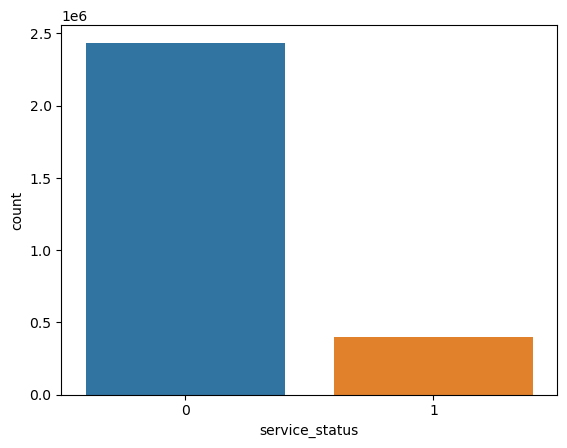

In [61]:
sns.countplot(data=train, x='service_status');

Мы убедились, что значения целевой переменной несбалансированы, преобладает класс клиентов, которые не отменяют бронирование.

## Список гипотез

Далее сформулируем гипотезы:

1) Наличие детей не влияет на отмену бронирования;
2) Клиентский сегмент не влияет на отмену бронирования;
3) Стоимость проживания на одного человека за сутки не влияет на отмену бронирования;   
4) Сезонность отеля не влияет на отмену бронирования;  
5) Количество дней до заезда с момента бронирования не влияет на отмену бронирования.

## Проверка гипотезы 1

Для проверки первой гипотезы сформируем новый столбцец в нашем датафрейме, который будет содержать значение 1 если клиент заезжает с детьми и 0 если нет.

In [62]:
train_["has_children"] = train_["service_child_cnt"].apply(lambda x: 1 if x > 0 else 0).astype(object)

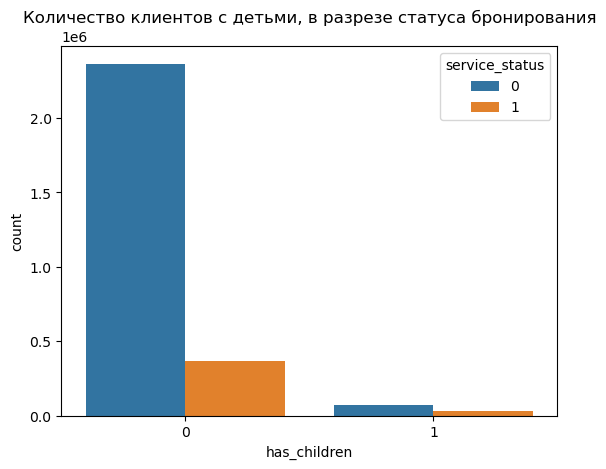

In [63]:
sns.countplot(data=train_, x='has_children', hue='service_status').set_title('Количество клиентов с детьми, в разрезе статуса бронирования');

Представленный выше график демонстирует, что среди клиентов с детьми доля отмен бронирования выше, чем среди клиентов без детей.

In [64]:
public_test_["has_children"] = public_test_["service_child_cnt"].apply(lambda x: 1 if x > 0 else 0).astype(object)
private_test_["has_children"] = private_test_["service_child_cnt"].apply(lambda x: 1 if x > 0 else 0).astype(object)

## Проверка гипотезы 2

Проверим гипотезу 2: клиентский сегмент не влияет на отмену бронирования.

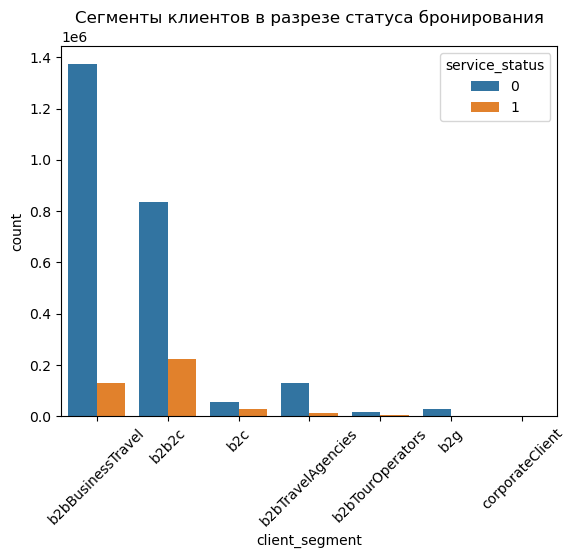

In [65]:
sns.countplot(data=train_, x='client_segment', hue='service_status').set_title('Сегменты клиентов в разрезе статуса бронирования')
plt.xticks(rotation=45);

Гипотезу о том, что сегмент клиента не вляет на отмену бронирования необходимо отвергуть.  
Так как, например, в сегменте b2c доля отмен бронирований составляет около 50%, в то время как в сегменте b2bBuisinessTravel доля отмен весьма мала.

## Проверка гипотезы 3

Проверим гипотезу 3: стоимость проживания на одного человека за сутки не влияет на отмену бронирования.

<Axes: xlabel='price_per_day_one_person', ylabel='service_status'>

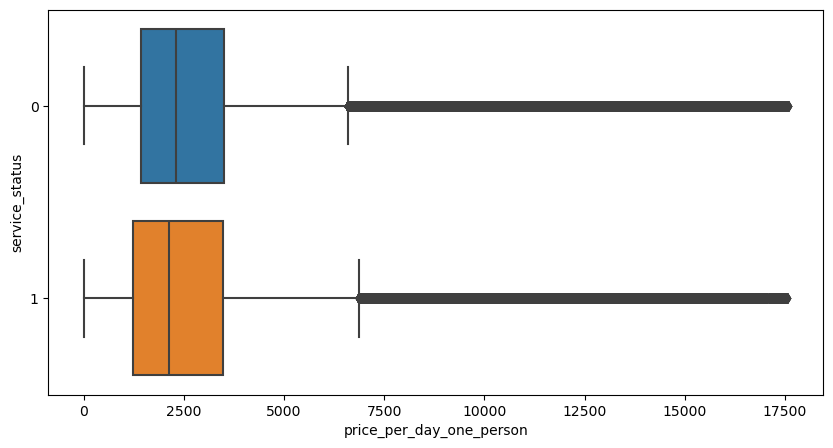

In [66]:
plt.figure(figsize=(10,5))
sns.boxplot(data=train_, x='price_per_day_one_person', y='service_status')

Данный график не противоречит гипотезе о том, что стоимость проживания на одного человека за сутки не влияет на отмену бронирования.

## Проверка гипотезы 4

Проверим гипотезу 4: сезонность отеля не влияет на отмену бронирования.  
Воспользуемся точным тестом Фишера.

In [67]:
train_['hotel_seasonal'] = train_['hotel_seasonal'].astype(int)
train_['service_status'] = train_['service_status'].astype(int)

In [68]:
# Оценка относительного риска и точный тест Фишера.
# На вход подаются названия колонок, содержащих фактор риска и исход.
def safeRiskCalc(numerator, denumerator):
  if denumerator != 0:
    return str(round(numerator / denumerator*100,2))
  else:
    return '---'

def riskEstimation(factorRisk, outcome):
  expRiskOutcomeYes = len(train_[(train_[factorRisk] == 1) & (train_[outcome] == 1)].index)
  expRiskOutcomeNo = len(train_[(train_[factorRisk] == 1) & (train_[outcome] == 0)].index)
  expRisk = expRiskOutcomeYes + expRiskOutcomeNo

  controlOutcomeYes = len(train_[(train_[factorRisk] == 0) & (train_[outcome] == 1)].index)
  controlOutcomeNo = len(train_[(train_[factorRisk] == 0) & (train_[outcome] == 0)].index)
  control = controlOutcomeYes + controlOutcomeNo

  pt = PrettyTable()

  cellYY = str(expRiskOutcomeYes) + ' (' + safeRiskCalc(expRiskOutcomeYes, expRisk) + ' %)'
  cellYN = str(expRiskOutcomeNo) + ' (' + safeRiskCalc(expRiskOutcomeNo, expRisk) + ' %)'
  cellNY = str(controlOutcomeYes) + ' (' + safeRiskCalc(controlOutcomeYes, control) + ' %)'
  cellNN = str(controlOutcomeNo) + ' (' + safeRiskCalc(controlOutcomeNo, control) + ' %)'

  pt.field_names = ["   ", outcome + " = Да", outcome + " = Нет", "Итого"]
  pt.add_row([factorRisk + " = Да",   cellYY, cellYN, expRisk])
  pt.add_row([factorRisk + " = Нет", cellNY, cellNN, control])
  pt.add_row(["Итого", expRiskOutcomeYes + controlOutcomeYes, expRiskOutcomeNo + controlOutcomeNo,  expRisk + control])
  print(pt)

  try:
    RR = relative_risk(expRiskOutcomeYes, expRiskOutcomeYes + expRiskOutcomeNo, controlOutcomeYes, controlOutcomeYes + controlOutcomeNo)
    print('RR =', round(RR.relative_risk, 3))
    CIlow =  round(RR.confidence_interval(confidence_level=0.95).low, 2)
    CIhigh = round(RR.confidence_interval(confidence_level=0.95).high, 2)
    print('CI = [', CIlow, '; ', CIhigh, ']', sep = '')
  except:
    print('Невозможно найти RR')

  fisherTest = fisher_exact([[expRiskOutcomeYes, expRiskOutcomeNo], [controlOutcomeYes, controlOutcomeNo]])
  print(f'Точный тест Фишера p-value = {fisherTest[1]:e}')

In [69]:
riskEstimation('hotel_seasonal', 'service_status')

+----------------------+---------------------+----------------------+---------+
|                      | service_status = Да | service_status = Нет |  Итого  |
+----------------------+---------------------+----------------------+---------+
| hotel_seasonal = Да  |    7160 (28.83 %)   |   17675 (71.17 %)    |  24835  |
| hotel_seasonal = Нет |   388279 (13.83 %)  |  2419438 (86.17 %)   | 2807717 |
|        Итого         |        395439       |       2437113        | 2832552 |
+----------------------+---------------------+----------------------+---------+
RR = 2.085
CI = [2.04; 2.13]
Точный тест Фишера p-value = 0.000000e+00


Так как p-value < 0.05, мы отвергаем нулевую гипотезу о том, что сезонность отеля не вляет на отмену бронирования.

## Проверка гипотезы 5

Проверим гипотезу 5: количество дней до заезда с момента бронирования не влияет на отмену бронирования.

(-20.0, 40.0)

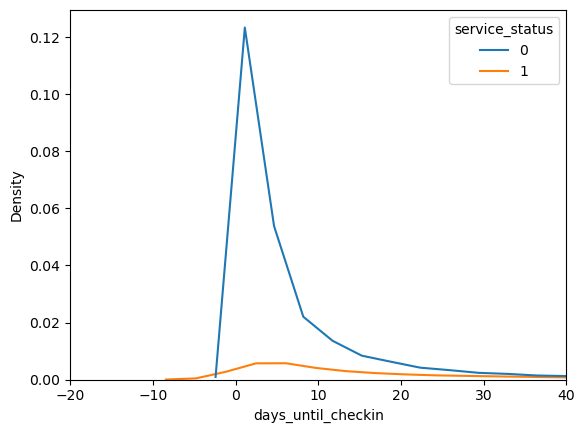

In [70]:
sns.kdeplot(data=train, x="days_until_checkin", hue="service_status")
plt.xlim(-20, 40)

Картина на данном графике не предоставляет информации для отвержения гипотезы о том, что количество дней до заезда влияет на отмену бронирования.

# Удаление сильно коррелирующих признаков

In [71]:
train_.corr(numeric_only=True).style.background_gradient(cmap='coolwarm')

,service_price,service_child_cnt,service_people_cnt,hotel_seasonal,service_status,length_of_stay,days_until_checkin,price_per_day_one_person
service_price,1.000000,0.076665,0.091180,0.044226,0.092662,0.738780,0.194638,0.296229
service_child_cnt,0.076665,1.000000,0.605698,0.031721,0.086579,-0.003578,0.119873,-0.156482
service_people_cnt,0.091180,0.605698,1.000000,0.047013,0.105504,-0.002278,0.184606,-0.456198
hotel_seasonal,0.044226,0.031721,0.047013,1.000000,0.040351,0.055761,0.071967,-0.037655
service_status,0.092662,0.086579,0.105504,0.040351,1.000000,0.056797,0.293291,-0.009894
length_of_stay,0.738780,-0.003578,-0.002278,0.055761,0.056797,1.000000,0.124551,-0.018405
days_until_checkin,0.194638,0.119873,0.184606,0.071967,0.293291,0.124551,1.000000,-0.021849
price_per_day_one_person,0.296229,-0.156482,-0.456198,-0.037655,-0.009894,-0.018405,-0.021849,1.000000


In [72]:
train_ = train_.drop(columns='service_price')

In [73]:
public_test_ = public_test_.drop(columns='service_price')
private_test_ = private_test_.drop(columns='service_price')

# Приведение категориальных признаков к типу object

In [74]:
train_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2832552 entries, 0 to 2832809
Data columns (total 14 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   service_child_cnt         float64
 1   service_people_cnt        float64
 2   client_segment            object 
 3   country_name              object 
 4   city_name                 object 
 5   category_star             object 
 6   hotel_type                object 
 7   hotel_seasonal            int32  
 8   room_category             object 
 9   service_status            int32  
 10  length_of_stay            int64  
 11  days_until_checkin        int64  
 12  price_per_day_one_person  float64
 13  has_children              object 
dtypes: float64(3), int32(2), int64(2), object(7)
memory usage: 302.5+ MB


In [75]:
train_['hotel_seasonal'] = train_['hotel_seasonal'].astype(object)
public_test_['hotel_seasonal'] = public_test_['hotel_seasonal'].astype(object)
private_test_['hotel_seasonal'] = private_test_['hotel_seasonal'].astype(object)

In [76]:
cat_features.append('has_children')

In [77]:
cat_features

['client_segment',
 'country_name',
 'city_name',
 'category_star',
 'hotel_type',
 'hotel_seasonal',
 'room_category',
 'has_children']

In [80]:
train_temp = train_.copy()
public_test_temp = public_test_.copy()
private_test_temp = private_test_.copy()

# Обучение и тестирование модели XGBClassifier

In [83]:
train_temp[cat_features] = train_temp[cat_features].astype("category")
public_test_temp[cat_features] = public_test_temp[cat_features].astype("category")
private_test_temp[cat_features] = private_test_temp[cat_features].astype("category")

In [84]:
X = train_temp.drop(columns=['service_status'])
y = train_temp['service_status']

In [85]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [86]:
model = xgb.XGBClassifier(random_state=42, 
                       objective='binary:logistic', 
                       enable_categorical=True, 
                       early_stopping_rounds=50, 
                       n_estimators=500)

In [87]:
model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_val, y_val)], 
          verbose=True);

[0]	validation_0-logloss:0.38151	validation_1-logloss:0.38152
[1]	validation_0-logloss:0.36496	validation_1-logloss:0.36495
[2]	validation_0-logloss:0.35528	validation_1-logloss:0.35526
[3]	validation_0-logloss:0.34942	validation_1-logloss:0.34942
[4]	validation_0-logloss:0.34579	validation_1-logloss:0.34580
[5]	validation_0-logloss:0.34356	validation_1-logloss:0.34361
[6]	validation_0-logloss:0.34216	validation_1-logloss:0.34226
[7]	validation_0-logloss:0.34126	validation_1-logloss:0.34140
[8]	validation_0-logloss:0.34065	validation_1-logloss:0.34084
[9]	validation_0-logloss:0.34021	validation_1-logloss:0.34043
[10]	validation_0-logloss:0.33987	validation_1-logloss:0.34012
[11]	validation_0-logloss:0.33964	validation_1-logloss:0.33991
[12]	validation_0-logloss:0.33940	validation_1-logloss:0.33972
[13]	validation_0-logloss:0.33924	validation_1-logloss:0.33959
[14]	validation_0-logloss:0.33913	validation_1-logloss:0.33951
[15]	validation_0-logloss:0.33899	validation_1-logloss:0.33941
[1

In [88]:
print("Лучшая Итерация: {}".format(model.get_booster().best_iteration))

Лучшая Итерация: 471


In [89]:
results = model.evals_result()

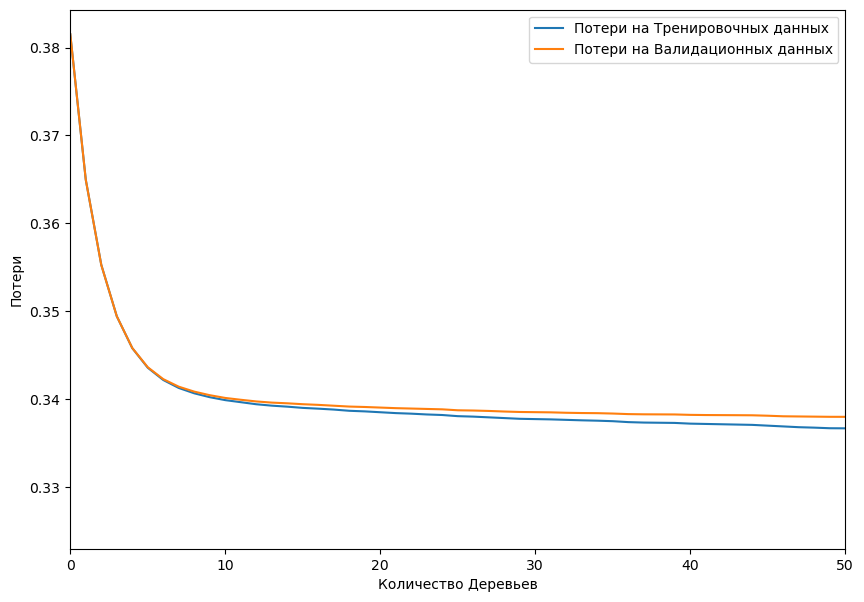

In [90]:
plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["logloss"], label="Потери на Тренировочных данных")
plt.plot(results["validation_1"]["logloss"], label="Потери на Валидационных данных")
plt.xlabel("Количество Деревьев")
plt.ylabel("Потери")
plt.xlim(0, 50)
plt.legend();

График выше демонстрирует, что начиная с 10, количество деревьев не приводит к существенному уменьшению функции потерь.

In [91]:
def calculate_metric(model_pipe, X, y, metric = f1_score):
    """Расчет метрики.
    Параметры:
    ===========
    model_pipe: модель или pipeline
    X: признаки
    y: истинные значения
    metric: метрика
    """
    y_model = model_pipe.predict(X)
    return metric(y, y_model, average='macro')

In [92]:
print(f"f1_macro на тренировочной выборке: {calculate_metric(model, X_train, y_train):.4f}")
print(f"f1_macro на валидационной выборке: {calculate_metric(model, X_val, y_val):.4f}")

f1_macro на тренировочной выборке: 0.5853
f1_macro на валидационной выборке: 0.5668


# Настройка гиперпараметров

Для поиска оптимальных гиперпараметров воспользуемся Optuna.

In [93]:
def f1_macro(preds, dtrain):
    labels = dtrain.get_label()
    preds = np.argmax(preds, axis=1)
    f1 = f1_score(labels, preds, average='macro')
    return 'f1_macro', f1

In [95]:
def objective(trial):

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 10, 100),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'scale_pos_weight': trial.suggest_int('scale_pos_weight', 1, 3),

    }

    estimator = xgb.XGBClassifier(**params, random_state=42, eval_metric=f1_macro,
                                  objective='binary:logistic',
                                    enable_categorical=True)

    # -- Указываем тип кросс-валидации
    cv=ShuffleSplit(n_splits=5, #на сколько разбиваем
                    random_state=42)

    # -- Оцениваем по кросс-валидации
    score = cross_val_score(estimator,
                            X, y,
                            scoring='f1_macro',
                            cv = cv,
                            n_jobs=-1
                            )

    final_score = score.mean() # усредняем по этапам кросс-валидации

    return final_score

In [96]:
study_XGB_final = optuna.create_study(direction="maximize",
                            study_name="study_XGB_final",
                            sampler=optuna.samplers.TPESampler(),
                            pruner=optuna.pruners.HyperbandPruner()
                            )
study_XGB_final.optimize(objective,
               n_trials=50,
               n_jobs=-1
               )

[I 2024-05-28 22:45:10,149] A new study created in memory with name: study_XGB_final
[I 2024-05-28 22:53:53,605] Trial 2 finished with value: 0.4632214629142946 and parameters: {'max_depth': 3, 'learning_rate': 0.13396583817341437, 'n_estimators': 34, 'min_child_weight': 9, 'gamma': 0.04043655099817147, 'subsample': 0.03436897913141207, 'colsample_bytree': 0.012932925578921886, 'reg_alpha': 0.00033729988120883756, 'reg_lambda': 0.33268965236704856, 'scale_pos_weight': 1}. Best is trial 2 with value: 0.4632214629142946.
[I 2024-05-28 22:54:55,285] Trial 1 finished with value: 0.46247415163731026 and parameters: {'max_depth': 7, 'learning_rate': 0.06636482784061794, 'n_estimators': 29, 'min_child_weight': 7, 'gamma': 0.015692519004890108, 'subsample': 0.46278178870711395, 'colsample_bytree': 0.022223190080194487, 'reg_alpha': 0.0036922719032135413, 'reg_lambda': 1.5703596414327742e-06, 'scale_pos_weight': 1}. Best is trial 2 with value: 0.4632214629142946.
[I 2024-05-28 22:58:00,747] Tri

In [97]:
optuna.visualization.plot_optimization_history(study_XGB_final)

In [98]:
optuna.visualization.plot_param_importances(study_XGB_final)

Можно увидеть, что найденные гиперпараметры при помощи Optuna позволили увеличить значение метрики f1_macro с 0.56 до 0.66.  
Данное значение можно считать хорошим, так данные в датасете являются очень несбалансированными и достичь каких-то   
высоких значений достаточно тяжело.  
Наиболее важным для предсказаний оказался гиперпараметр - *scale_pos_weight*, так как именно он отвечает за увеличение весов  
предсказаний для объектов менее распространенного класса.

In [100]:
study_XGB_final.best_params

{'max_depth': 9,
 'learning_rate': 0.4142535996928089,
 'n_estimators': 36,
 'min_child_weight': 5,
 'gamma': 4.2677778709826046e-08,
 'subsample': 0.32786369479754196,
 'colsample_bytree': 0.2516496916145146,
 'reg_alpha': 0.00020977675567191852,
 'reg_lambda': 0.005863419014015099,
 'scale_pos_weight': 3}

In [101]:
final_model = xgb.XGBClassifier(**study_XGB_final.best_params, random_state=42, eval_metric=f1_macro,
                                  objective='binary:logistic',
                                  enable_categorical=True)

In [102]:
final_model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.2516496916145146, device=None,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric=<function f1_macro at 0x000001F1D8C32660>,
              feature_types=None, gamma=4.2677778709826046e-08,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4142535996928089,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=36, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [103]:
X_public_test = public_test_temp
X_private_test = private_test_temp

In [104]:
pred_public_test = np.round(final_model.predict(X_public_test))
np.savetxt("submission_pub.csv", pred_public_test, fmt="%d", delimiter="")

In [105]:
pred_private_test = np.round(final_model.predict(X_private_test))
np.savetxt("submission_pr.csv", pred_private_test, fmt="%d", delimiter="")

# Сохранение модели

In [106]:
from joblib import dump

dump(final_model, 'final_model.joblib')

['final_model.joblib']